In [30]:
!pip install pyvi nltk torchmetrics

import nltk
# Tải dữ liệu ngôn ngữ cho NLTK (Bắt buộc cho METEOR)
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt_tab') # Cập nhật mới nhất cần cái này

import os
import torch
import numpy as np
from torchmetrics.text import BLEUScore # BLEU thường ổn định, giữ lại
from nltk.translate.meteor_score import meteor_score # Dùng cái này thay thế
from tqdm import tqdm
from pyvi import ViTokenizer

print("Đã cài đặt và nhập thư viện thành công. Sẵn sàng đánh giá!")

Đã cài đặt và nhập thư viện thành công. Sẵn sàng đánh giá!


[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [14]:
import os
import json
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from PIL import Image
from pyvi import ViTokenizer
from collections import Counter
# from torchmetrics.text import BLEUScore, METEORScore
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [15]:
CAPTION_JSON_PATH = "/kaggle/input/vietnamese-coco-2017-image-caption-dataset/captions_train2017_trans.json"
IMAGE_DIR_PATH = "/kaggle/input/coco-2017-dataset/coco2017/train2017"

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# Số lượng ảnh muốn lấy
NUM_IMAGES_TO_TAKE = 10000

Using device: cuda


In [16]:
# %% [code]
def load_and_filter_data(json_path, image_dir, num_images):
    print("Đang đọc file JSON...")
    with open(json_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    
    annotations = data['annotations']
    
    # 1. Lấy danh sách tất cả ID ảnh có trong file caption
    # Cần đảm bảo ảnh đó thực sự tồn tại trong thư mục
    print("Đang kiểm tra file ảnh...")
    available_images = set(os.listdir(image_dir))
    
    # Gom nhóm caption theo image_id
    img_id_to_captions = {}
    for ann in annotations:
        img_id = ann['image_id']
        # Format tên file của COCO: 000000xxxxxx.jpg
        file_name = f"{str(img_id).zfill(12)}.jpg"
        
        if file_name in available_images:
            if img_id not in img_id_to_captions:
                img_id_to_captions[img_id] = []
            img_id_to_captions[img_id].append(ann['caption'])
            
    # 2. Lấy đúng 10.000 ảnh duy nhất
    all_valid_img_ids = list(img_id_to_captions.keys())
    
    if len(all_valid_img_ids) < num_images:
        print(f"Cảnh báo: Chỉ tìm thấy {len(all_valid_img_ids)} ảnh hợp lệ.")
        selected_img_ids = all_valid_img_ids
    else:
        selected_img_ids = all_valid_img_ids[:num_images]
        
    print(f"Đã chọn {len(selected_img_ids)} ảnh duy nhất.")
    
    # 3. Tạo DataFrame
    records = []
    for img_id in selected_img_ids:
        file_name = f"{str(img_id).zfill(12)}.jpg"
        full_path = os.path.join(image_dir, file_name)
        captions = img_id_to_captions[img_id]
        
        for cap in captions:
            records.append({
                "image_path": full_path,
                "caption": cap,
                "image_id": img_id
            })
            
    return pd.DataFrame(records)

# --- THỰC HIỆN LOAD DATA ---
df_full = load_and_filter_data(CAPTION_JSON_PATH, IMAGE_DIR_PATH, NUM_IMAGES_TO_TAKE)

# --- CHIA TRAIN / VALIDATION ---
# Chia theo Image ID để đảm bảo caption của cùng 1 ảnh không nằm lẫn ở 2 tập
unique_ids = df_full['image_id'].unique()
train_ids, val_ids = train_test_split(unique_ids, test_size=0.15, random_state=42) # 15% cho Val

train_df = df_full[df_full['image_id'].isin(train_ids)].reset_index(drop=True)
val_df = df_full[df_full['image_id'].isin(val_ids)].reset_index(drop=True)

# Gom caption cho tập Val (để đánh giá BLEU sau này)
val_df_grouped = val_df.groupby('image_path')['caption'].apply(list).reset_index()

print(f"Train set: {len(train_df)} captions (từ {len(train_ids)} ảnh)")
print(f"Val set: {len(val_df_grouped)} ảnh (đã gộp captions)")

Đang đọc file JSON...
Đang kiểm tra file ảnh...
Đã chọn 10000 ảnh duy nhất.
Train set: 42526 captions (từ 8500 ảnh)
Val set: 1500 ảnh (đã gộp captions)


In [17]:
class Vocabulary:
    def __init__(self, freq_threshold=2):
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}
        self.freq_threshold = freq_threshold

    def __len__(self):
        return len(self.itos)

    @staticmethod
    def tokenizer_vi(text):
        # Sử dụng PyVi để tách từ tiếng Việt
        text = ViTokenizer.tokenize(text)
        return text.lower().split()

    def build_vocabulary(self, sentence_list):
        frequencies = Counter()
        idx = 4
        
        for sentence in tqdm(sentence_list, desc="Building Vocab"):
            for word in self.tokenizer_vi(sentence):
                frequencies[word] += 1

                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1

    def numericalize(self, text):
        tokenized_text = self.tokenizer_vi(text)
        return [
            self.stoi[token] if token in self.stoi else self.stoi["<UNK>"]
            for token in tokenized_text
        ]

# Tạo Vocab từ tập Train
vocab = Vocabulary(freq_threshold=3) # Bỏ qua từ xuất hiện dưới 3 lần
vocab.build_vocabulary(train_df['caption'].tolist())
print(f"Kích thước bộ từ điển: {len(vocab)}")

# --- DATASET CLASS ---
class COCODataset(Dataset):
    def __init__(self, df, vocab, transform=None):
        self.df = df
        self.vocab = vocab
        self.transform = transform
        self.imgs = df['image_path'].tolist()
        self.captions = df['caption'].tolist()

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        caption = self.captions[idx]
        img_path = self.imgs[idx]
        
        image = Image.open(img_path).convert("RGB")
        if self.transform is not None:
            image = self.transform(image)

        numericalized_caption = [self.vocab.stoi["<SOS>"]]
        numericalized_caption += self.vocab.numericalize(caption)
        numericalized_caption.append(self.vocab.stoi["<EOS>"])

        return image, torch.tensor(numericalized_caption)

# --- COLLATOR (ĐỂ PADDING BATCH) ---
class MyCollate:
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx

    def __call__(self, batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs, dim=0)
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=True, padding_value=self.pad_idx)
        return imgs, targets

# --- TRANSFORMS & DATALOADERS ---
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

# Val transform không có augmentation
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

train_dataset = COCODataset(train_df, vocab, transform=transform)
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=64,
    num_workers=2,
    shuffle=True,
    pin_memory=True,
    collate_fn=MyCollate(pad_idx=vocab.stoi["<PAD>"])
)

# Loader cho validation (chỉ cần trả về ảnh và list caption gốc)
class ValDataset(Dataset):
    def __init__(self, df_grouped, transform=None):
        self.df = df_grouped
        self.transform = transform
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image = Image.open(row['image_path']).convert("RGB")
        if self.transform: image = self.transform(image)
        return image, row['captions_list']

val_dataset = ValDataset(val_df_grouped, transform=val_transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

Building Vocab: 100%|██████████| 42526/42526 [00:07<00:00, 5674.13it/s]

Kích thước bộ từ điển: 2975


In [18]:
# %% [code]
class EncoderCNN(nn.Module):
    def __init__(self, embed_size, train_CNN=False):
        super(EncoderCNN, self).__init__()
        # ResNet50 pretrained
        resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        
        # Bỏ lớp fully connected cuối cùng, lấy context features
        modules = list(resnet.children())[:-1] 
        self.resnet = nn.Sequential(*modules)
        
        # Linear layer để đưa về đúng embed_size
        self.embed = nn.Linear(resnet.fc.in_features, embed_size)
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)
        
        # Freeze CNN (không train lại ResNet để tiết kiệm thời gian và tránh overfit với 10k ảnh)
        for param in self.resnet.parameters():
            param.requires_grad = train_CNN

    def forward(self, images):
        features = self.resnet(images)
        features = features.reshape(features.size(0), -1)
        features = self.embed(features)
        features = self.bn(features)
        return features

class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        
        # LSTM
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        
        # Linear output
        self.linear = nn.Linear(hidden_size, vocab_size)

    def forward(self, features, captions):
        # features: (Batch, Embed_Size)
        # captions: (Batch, Seq_Len) - Input words
        
        # Bỏ token <EOS> ở cuối input caption vì chúng ta dự đoán nó
        embeddings = self.embed(captions[:, :-1]) 
        
        # Nối Feature ảnh vào đầu chuỗi embedding (Image as context at step 0)
        inputs = torch.cat((features.unsqueeze(1), embeddings), 1)
        
        hiddens, _ = self.lstm(inputs)
        outputs = self.linear(hiddens)
        return outputs
    
    def generate(self, features, vocab, max_len=20):
        # Inference mode
        result_caption = []
        
        inputs = features.unsqueeze(1) # (Batch, 1, Embed)
        states = None
        
        for _ in range(max_len):
            hiddens, states = self.lstm(inputs, states)
            output = self.linear(hiddens.squeeze(1))
            predicted = output.argmax(1)
            
            if predicted.item() == vocab.stoi["<EOS>"]:
                break
                
            # Append từ vào kết quả (chuyển ID sang từ)
            word = vocab.itos[predicted.item()]
            result_caption.append(word)
            
            # Input cho bước tiếp theo
            inputs = self.embed(predicted).unsqueeze(1)
            
        return ' '.join(result_caption)

class CNNtoRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(CNNtoRNN, self).__init__()
        self.encoder = EncoderCNN(embed_size)
        self.decoder = DecoderRNN(embed_size, hidden_size, vocab_size, num_layers)

    def forward(self, images, captions):
        features = self.encoder(images)
        outputs = self.decoder(features, captions)
        return outputs

# --- KHỞI TẠO MODEL ---
embed_size = 256
hidden_size = 512
vocab_size = len(vocab)
num_layers = 1 # LSTM Single layer
learning_rate = 3e-4
num_epochs = 20

model = CNNtoRNN(embed_size, hidden_size, vocab_size, num_layers).to(DEVICE)
criterion = nn.CrossEntropyLoss(ignore_index=vocab.stoi["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 182MB/s] 


Bắt đầu huấn luyện 20 epochs...


Epoch 1/20: 100%|██████████| 665/665 [03:41<00:00,  3.01it/s, loss=2.78]


Epoch 1 completed. Avg Loss: 3.5606


Epoch 2/20: 100%|██████████| 665/665 [03:13<00:00,  3.44it/s, loss=2.21]


Epoch 2 completed. Avg Loss: 2.5983


Epoch 3/20: 100%|██████████| 665/665 [03:11<00:00,  3.47it/s, loss=2.51]


Epoch 3 completed. Avg Loss: 2.3445


Epoch 4/20: 100%|██████████| 665/665 [03:12<00:00,  3.45it/s, loss=2.42]


Epoch 4 completed. Avg Loss: 2.1940


Epoch 5/20: 100%|██████████| 665/665 [03:12<00:00,  3.46it/s, loss=2.04]


Epoch 5 completed. Avg Loss: 2.0845


Epoch 6/20: 100%|██████████| 665/665 [03:09<00:00,  3.50it/s, loss=2.21]


Epoch 6 completed. Avg Loss: 1.9979


Epoch 7/20: 100%|██████████| 665/665 [03:09<00:00,  3.50it/s, loss=1.96]


Epoch 7 completed. Avg Loss: 1.9225


Epoch 8/20: 100%|██████████| 665/665 [03:18<00:00,  3.35it/s, loss=1.83]


Epoch 8 completed. Avg Loss: 1.8558


Epoch 9/20: 100%|██████████| 665/665 [03:21<00:00,  3.30it/s, loss=1.92]


Epoch 9 completed. Avg Loss: 1.7957


Epoch 10/20: 100%|██████████| 665/665 [03:27<00:00,  3.20it/s, loss=1.86]


Epoch 10 completed. Avg Loss: 1.7393


Epoch 11/20: 100%|██████████| 665/665 [03:26<00:00,  3.22it/s, loss=1.94]


Epoch 11 completed. Avg Loss: 1.6868


Epoch 12/20: 100%|██████████| 665/665 [03:23<00:00,  3.26it/s, loss=1.68]


Epoch 12 completed. Avg Loss: 1.6364


Epoch 13/20: 100%|██████████| 665/665 [03:26<00:00,  3.21it/s, loss=1.8] 


Epoch 13 completed. Avg Loss: 1.5893


Epoch 14/20: 100%|██████████| 665/665 [03:22<00:00,  3.29it/s, loss=1.69]


Epoch 14 completed. Avg Loss: 1.5442


Epoch 15/20: 100%|██████████| 665/665 [03:23<00:00,  3.27it/s, loss=1.44]


Epoch 15 completed. Avg Loss: 1.4994


Epoch 16/20: 100%|██████████| 665/665 [03:22<00:00,  3.28it/s, loss=1.48]


Epoch 16 completed. Avg Loss: 1.4582


Epoch 17/20: 100%|██████████| 665/665 [03:25<00:00,  3.24it/s, loss=1.57]


Epoch 17 completed. Avg Loss: 1.4173


Epoch 18/20: 100%|██████████| 665/665 [03:28<00:00,  3.19it/s, loss=1.72]


Epoch 18 completed. Avg Loss: 1.3781


Epoch 19/20: 100%|██████████| 665/665 [03:25<00:00,  3.23it/s, loss=1.32]


Epoch 19 completed. Avg Loss: 1.3396


Epoch 20/20: 100%|██████████| 665/665 [03:29<00:00,  3.17it/s, loss=1.34]


Epoch 20 completed. Avg Loss: 1.3032


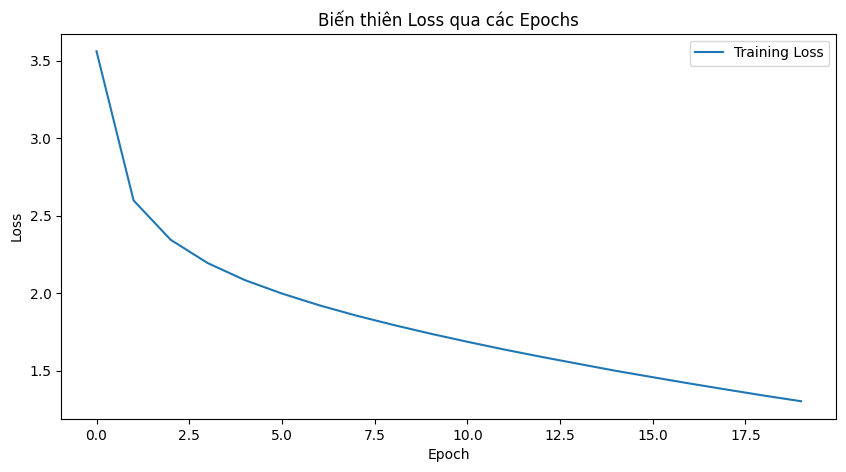

Đã lưu model.


In [19]:
# %% [code]
print(f"Bắt đầu huấn luyện {num_epochs} epochs...")
loss_history = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    # Sử dụng tqdm để hiện thanh tiến trình
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=True)
    
    for imgs, captions in loop:
        imgs = imgs.to(DEVICE)
        captions = captions.to(DEVICE)

        optimizer.zero_grad()
        
        outputs = model(imgs, captions)
        
        # Tính loss: So sánh output dự đoán với caption gốc (target)
        # output: (Batch, Seq_Len, Vocab_Size), target: (Batch, Seq_Len)
        loss = criterion(outputs.reshape(-1, outputs.shape[2]), captions.reshape(-1))
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    avg_loss = running_loss / len(train_loader)
    loss_history.append(avg_loss)
    print(f"Epoch {epoch+1} completed. Avg Loss: {avg_loss:.4f}")

# Vẽ biểu đồ Loss
plt.figure(figsize=(10, 5))
plt.plot(loss_history, label='Training Loss')
plt.title('Biến thiên Loss qua các Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Lưu model
torch.save(model.state_dict(), "resnet_lstm_model.pth")
print("Đã lưu model.")

In [23]:
if 'caption' in val_df_grouped.columns:
    val_df_grouped.rename(columns={'caption': 'captions_list'}, inplace=True)
    print("Đã đổi tên cột 'caption' -> 'captions_list'")

# 2. Kiểm tra lại các cột
print("Các cột hiện tại:", val_df_grouped.columns)

# 3. Khởi tạo lại ValDataset và DataLoader (để cập nhật thay đổi)
val_dataset = ValDataset(val_df_grouped, transform=val_transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

print("Đã cập nhật DataLoader thành công.")

Các cột hiện tại: Index(['image_path', 'captions_list'], dtype='object')
Đã cập nhật DataLoader thành công.


In [27]:
# %% [code]
# --- 1. Định nghĩa hàm Collate tùy chỉnh cho Validation ---
def val_collate_fn(batch):
    # batch là một list các tuple: [(img1, caps_list1), (img2, caps_list2), ...]
    
    # 1. Xử lý ảnh: Stack thành tensor (Batch, C, H, W)
    imgs = [item[0].unsqueeze(0) for item in batch]
    imgs = torch.cat(imgs, dim=0)
    
    # 2. Xử lý caption: Giữ nguyên dạng list of lists
    # Kết quả sẽ là một list dài bằng Batch Size
    caps_list = [item[1] for item in batch]
    
    return imgs, caps_list

# --- 2. Tạo lại Val Loader với collate_fn mới ---
print("Đang khởi tạo lại Val Loader với custom collate_fn...")
val_loader = DataLoader(
    val_dataset, 
    batch_size=32, 
    shuffle=False, 
    num_workers=2,
    collate_fn=val_collate_fn # <--- Thêm dòng này
)

Đang khởi tạo lại Val Loader với custom collate_fn...


In [29]:
# %% [code]
def evaluate_model(model, val_loader, vocab, device):
    model.eval()
    
    # Khởi tạo metrics
    bleu1 = BLEUScore(n_gram=1)
    bleu2 = BLEUScore(n_gram=2)
    bleu3 = BLEUScore(n_gram=3)
    bleu4 = BLEUScore(n_gram=4)
    
    candidates_text = [] 
    references_text = [] 
    meteor_scores = []   
    
    print("Đang chạy Inference và tính toán độ đo...")
    with torch.no_grad():
        for imgs, caps_list in tqdm(val_loader):
            imgs = imgs.to(device)
            
            # Mã hóa ảnh để lấy features (Batch_Size, Embed_Size)
            features = model.encoder(imgs)
            
            for i in range(imgs.size(0)):
                single_feature = features[i].unsqueeze(0) 
                
                # Sinh caption
                generated_cap = model.decoder.generate(single_feature, vocab)
                
                # Lấy caption gốc
                ref_caps = caps_list[i] 
                
                # Lưu dữ liệu BLEU
                candidates_text.append(generated_cap)
                references_text.append(ref_caps)
                
                gen_tokens = generated_cap.split() 
                ref_tokens_list = [ref.split() for ref in ref_caps]
                
                try:
                    score = meteor_score(ref_tokens_list, gen_tokens)
                    meteor_scores.append(score)
                except LookupError:
                    meteor_scores.append(0.0)
                
    avg_meteor = np.mean(meteor_scores)

    print("\n" + "="*30)
    print("   KẾT QUẢ ĐÁNH GIÁ MÔ HÌNH")
    print("="*30)
    print(f"BLEU-1: {bleu1(candidates_text, references_text).item():.4f}")
    print(f"BLEU-2: {bleu2(candidates_text, references_text).item():.4f}")
    print(f"BLEU-3: {bleu3(candidates_text, references_text).item():.4f}")
    print(f"BLEU-4: {bleu4(candidates_text, references_text).item():.4f}")
    print("-" * 30)
    print(f"METEOR: {avg_meteor:.4f}")
    print("="*30)
    
    print("\n--- VÍ DỤ THỰC TẾ ---")
    for i in range(min(3, len(candidates_text))):
        print(f"Ảnh {i+1}:")
        print(f"Model đoán: {candidates_text[i]}")
        print(f"Thực tế:    {references_text[i][0]}")

# --- CHẠY LẠI ĐÁNH GIÁ ---
if 'model' in globals():
    evaluate_model(model, val_loader, vocab, DEVICE)

Đang chạy Inference và tính toán độ đo...


100%|██████████| 47/47 [00:14<00:00,  3.23it/s]



   KẾT QUẢ ĐÁNH GIÁ MÔ HÌNH
BLEU-1: 0.4349
BLEU-2: 0.2824
BLEU-3: 0.1752
BLEU-4: 0.1047
------------------------------
METEOR: 0.3133

--- VÍ DỤ THỰC TẾ ---
Ảnh 1:
Model đoán: <SOS> một con hươu cao_cổ đứng trong một căn phòng với một người phụ_nữ .
Thực tế:    Hai con hươu cao cổ trong một căn phòng với những người nhìn chúng.
Ảnh 2:
Model đoán: <SOS> một chiếc máy_bay đang bay trên mặt_nước .
Thực tế:    Một chiếc máy bay bay trên mặt nước với hai hòn đảo gần đó.
Ảnh 3:
Model đoán: <SOS> một con cừu đứng cạnh một con cừu lớn hơn .
Thực tế:    Có ba She Eps đứng cùng nhau trên bãi cỏ.
